Markdown cell for User Personas and Product Features
- The biggest contributors to user satisfaction based on User_Satisfaction_Analysis.ipynb was the price of the device and the overall device performance.
- Our focus now will be to come up with user personas and product features that can reduce price and bolster performance.

Conduct a similar analysis on Performance_Score and see what features contribute most to performance. Then, create your own metric (feature engineering) to measure performance vs. price. Hint: Use a type of performance:price ratio.

In [50]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import kagglehub
from kagglehub import KaggleDatasetAdapter
import math
from ols_functions import ols_model, remove_correlated_variables
from ipywidgets import interact
%matplotlib inline

In [2]:
# Download the appropriate dataset
dataset_path = kagglehub.dataset_download("pratyushpuri/wearable-health-devices-performance-analysis")
print(dataset_path)

csv_file = os.listdir(dataset_path)[0]
df = pd.read_csv(os.path.join(dataset_path, csv_file))
display(df.head())

/Users/jordan/.cache/kagglehub/datasets/pratyushpuri/wearable-health-devices-performance-analysis/versions/1


,Test_Date,Device_Name,Brand,Model,Category,Price_USD,Battery_Life_Hours,Heart_Rate_Accuracy_Percent,Step_Count_Accuracy_Percent,Sleep_Tracking_Accuracy_Percent,Water_Resistance_Rating,User_Satisfaction_Rating,GPS_Accuracy_Meters,Connectivity_Features,Health_Sensors_Count,App_Ecosystem_Support,Performance_Score
0,2025-06-01,Fitbit Inspire 4,Fitbit,Inspire 4,Fitness Tracker,141.74,129.9,89.69,93.03,78.91,3ATM,6.5,NaN,"Bluetooth, WiFi",5,Cross-platform,68.4
1,2025-06-01,Apple Watch SE 3,Apple,Watch SE 3,Smartwatch,834.64,26.5,95.92,98.20,79.76,IP68,8.3,4.9,"WiFi, Bluetooth, NFC",8,iOS,60.1
2,2025-06-01,Fitbit Versa 4,Fitbit,Versa 4,Sports Watch,145.34,161.2,92.24,96.81,74.49,IPX8,6.0,1.7,Bluetooth,7,Cross-platform,59.3
3,2025-06-01,Polar Vantage V3,Polar,Vantage V3,Smartwatch,349.53,69.4,96.77,95.56,78.06,IP68,8.0,3.2,"WiFi, Bluetooth, NFC, LTE",12,Cross-platform,61.0
4,2025-06-01,Samsung Galaxy Watch FE,Samsung,Galaxy Watch FE,Smartwatch,502.43,39.7,92.27,98.15,75.23,IPX8,8.3,1.6,"WiFi, Bluetooth, NFC, LTE",14,Android/iOS,61.2


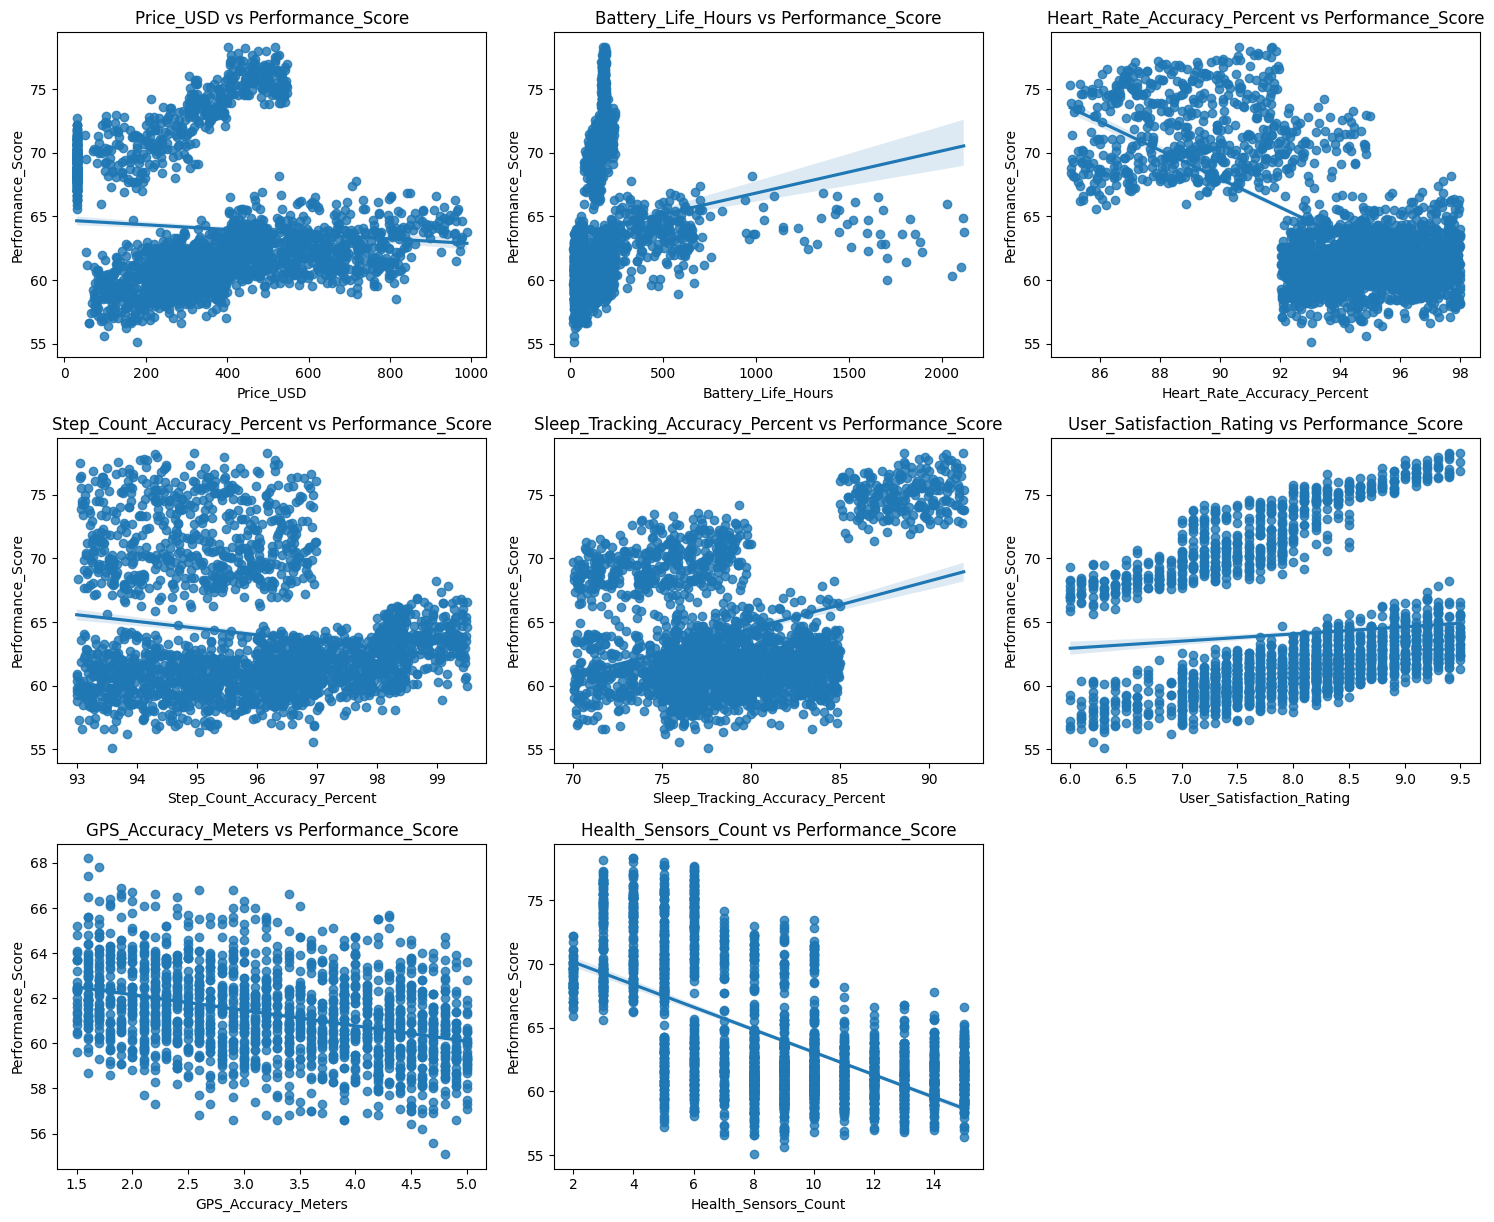

In [43]:
# Create scatterplots to visualize the relationships between performance and other variables
features_to_plot = [col for col in df.columns if col not in ['Performance_Score', 'Test_Date']]
numerical_features = [feature for feature in features_to_plot if df[feature].dtype != 'object']
categorical_features = [feature for feature in features_to_plot if feature not in numerical_features]
n_features = len(features_to_plot)


def plot_numerical(df):
    nrows = 5
    ncols = 3

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 20))
    axes = axes.flatten()
    plot_index = 0

    for feature in numerical_features:
        if plot_index >= len(axes):
            break
            
        ax = axes[plot_index]

        # Handle numerical variables with regression plots
        sns.regplot(data=df, x=feature, y='Performance_Score', ax=ax)
        
        ax.set_title(f'{feature} vs Performance_Score')
        plot_index += 1

    # Hide unused subplots
    for i in range(plot_index, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
plot_numerical(df)

It looks like there are some clusters forming in some of the relationships between the variables and performance. We can look into that more deeply later, but that is interesting. There is likely another characteristic that we have not observed that is causing these clusters to form. Maybe it depends on the device type or some other variable. These clusters are causing our lines of bestfit to not be truly representative of the variable's correlation to performance.

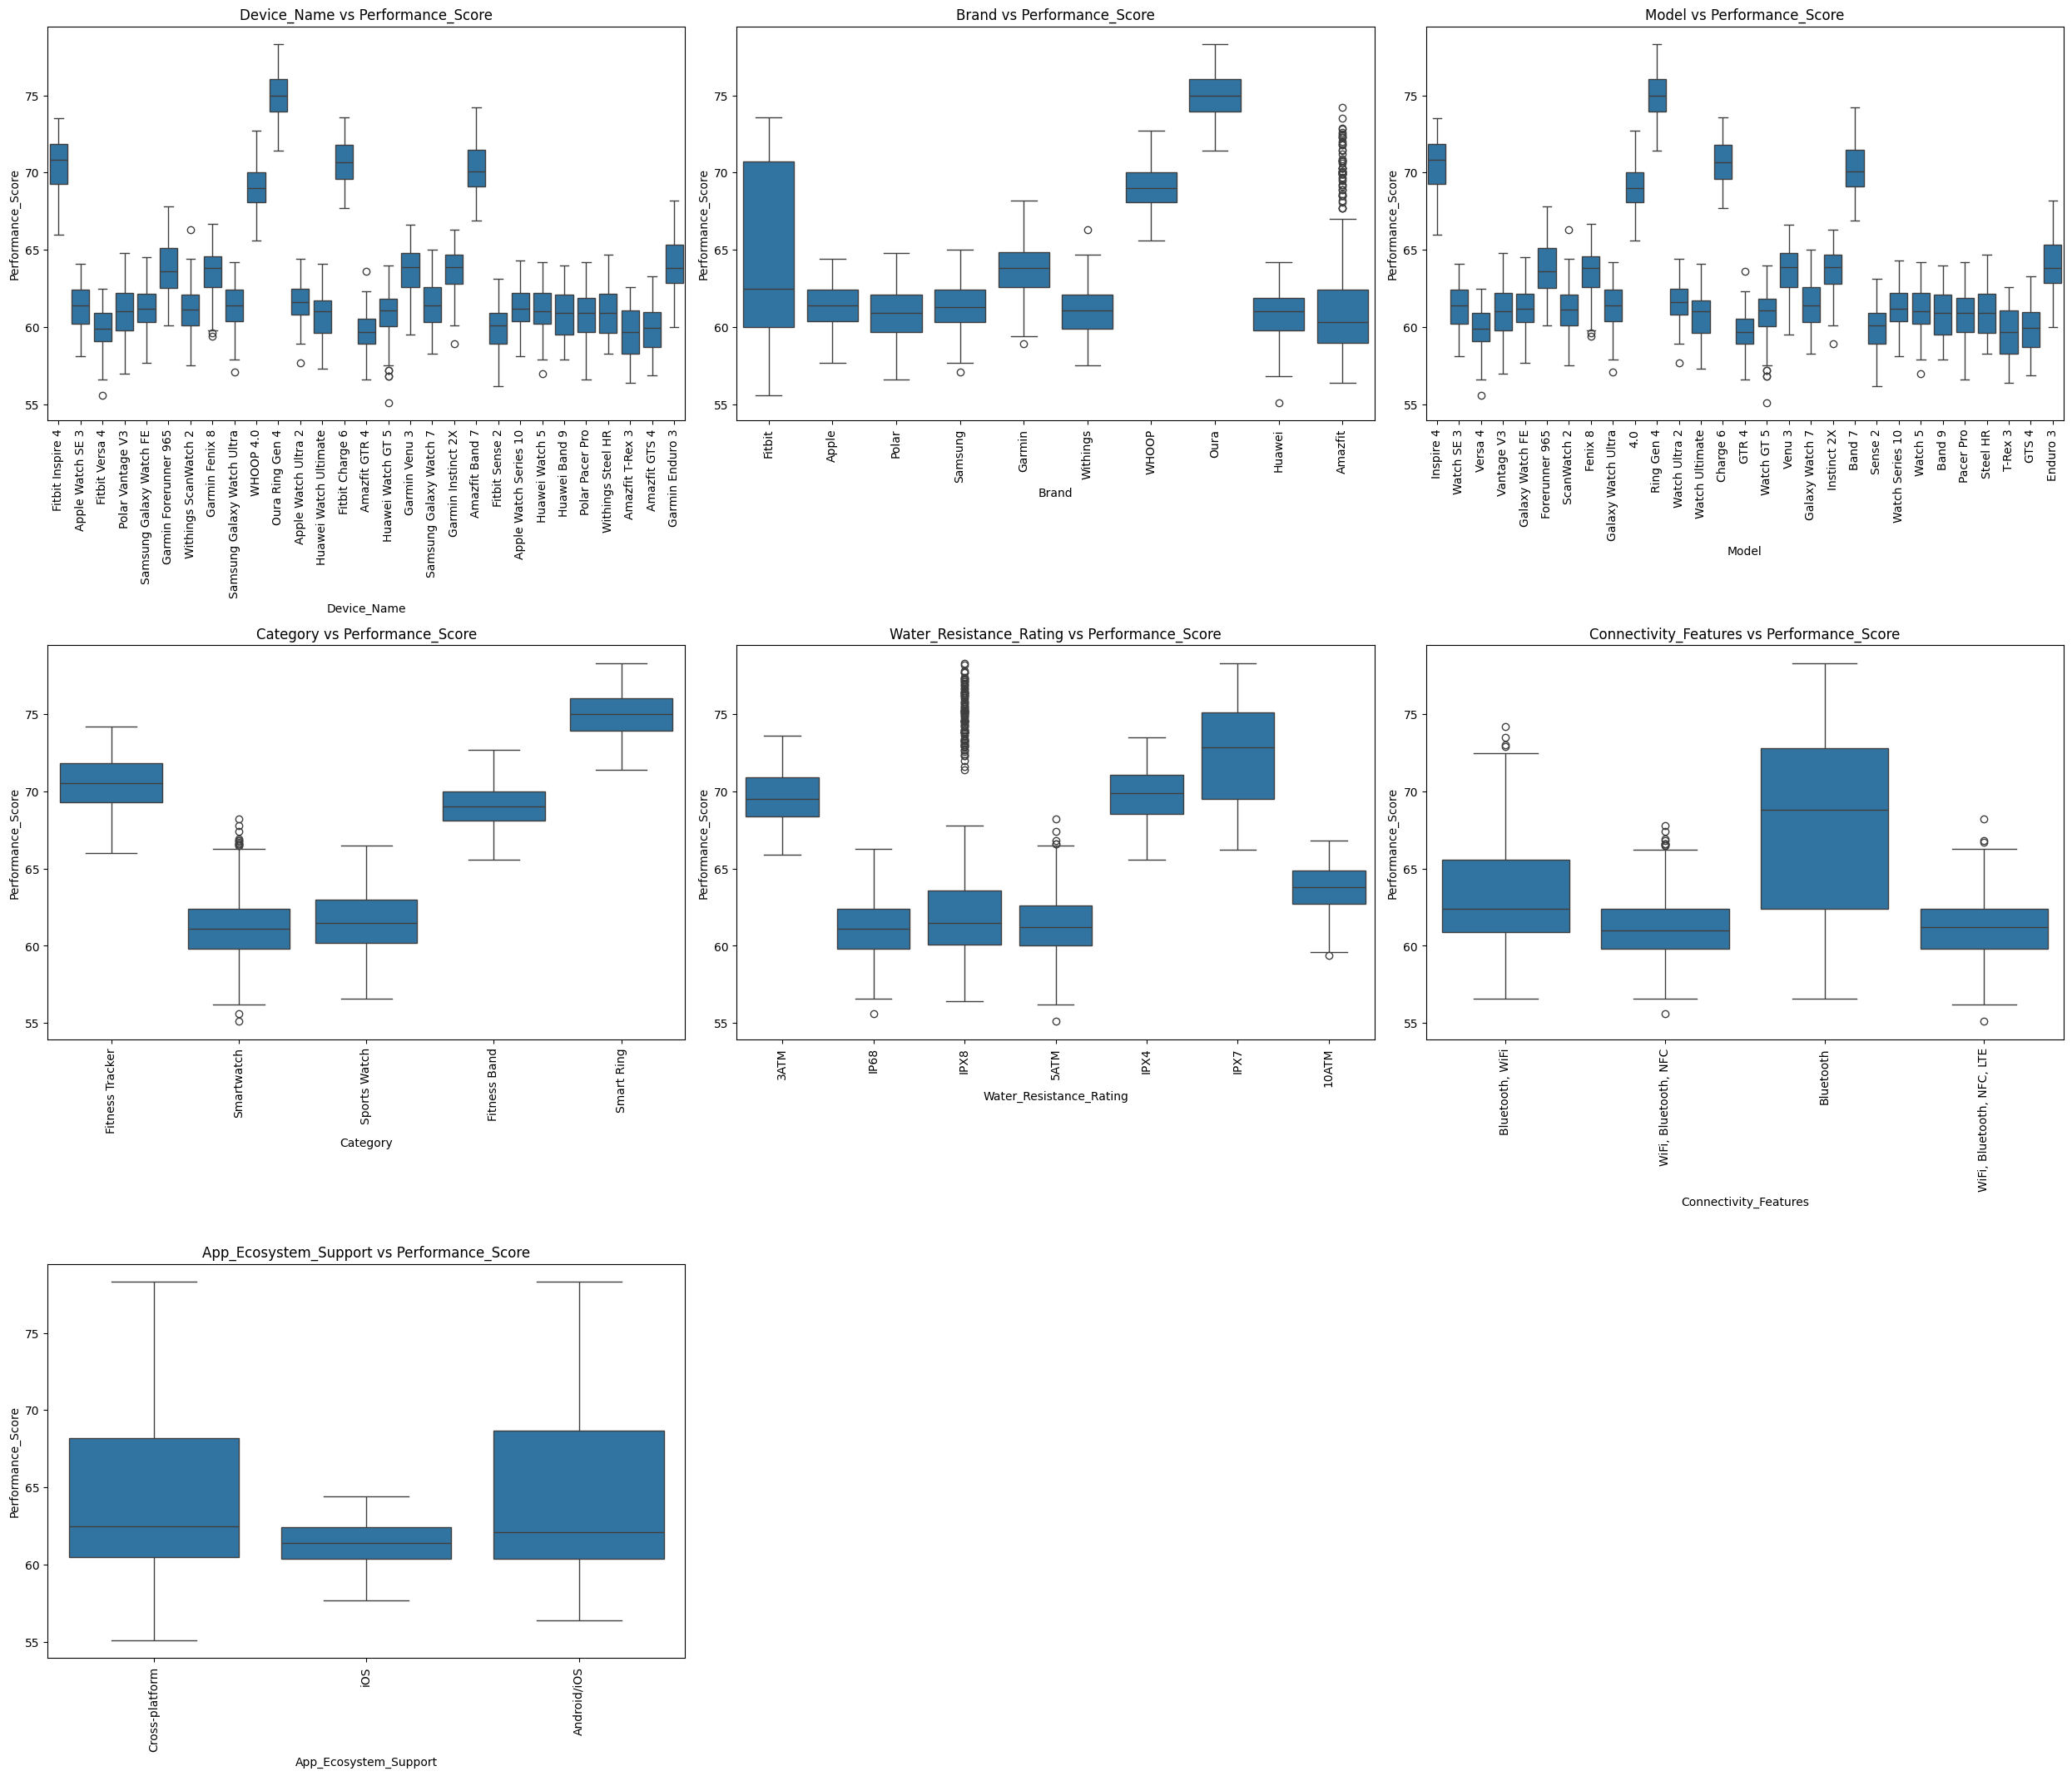

In [44]:
def plot_categorical(df):
    n_features = len(categorical_features)

    nrows = 5
    ncols = 3

    fig, axes = plt.subplots(nrows, ncols, figsize=(25, 35))
    axes = axes.flatten()
    plot_index = 0

    for feature in categorical_features:
        if plot_index >= len(axes):
            break
            
        ax = axes[plot_index]
        
        if df[feature].dtype == 'object':
            # Handle categorical variables with box plots
            sns.boxplot(data=df, x=feature, y='Performance_Score', ax=ax)
            ax.tick_params(axis='x', rotation=90)
            ax.set_title(f'{feature} vs Performance_Score')  # Added title
            
        plot_index += 1  # This was missing - increment the plot index

    # Hide unused subplots
    for i in range(plot_index, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
plot_categorical(df)

In [49]:
# IF INTERESTED, LOOK INTO THE CLUSTERS SEEN IN THE SCATTERPLOTS AND PLOT MORE ACCURATE BEST FIT LINES TO ANALYZE THE RELATIONSHIPS.
# We will now plot by brand 
brands = df['Brand'].unique()
def plot_by_brand(brand):
    #print(brand)
    #print(df.head())
    brand_df = df[df['Brand'] == brand]

    if len(brand_df) > 0:
        plot_numerical(brand_df)
        plot_categorical(brand_df)
        plt.show()

    else:
        print(f'No data found for brand {brand}')
    
interact(plot_by_brand, brand=brands)


interactive(children=(Dropdown(description='brand', options=('Fitbit', 'Apple', 'Polar', 'Samsung', 'Garmin', …

<function __main__.plot_by_brand(brand)>

['Test_Date', 'Device_Name', 'Brand', 'Model', 'Category', 'Price_USD', 'Battery_Life_Hours', 'Heart_Rate_Accuracy_Percent', 'Step_Count_Accuracy_Percent', 'Sleep_Tracking_Accuracy_Percent', 'Water_Resistance_Rating', 'User_Satisfaction_Rating', 'GPS_Accuracy_Meters', 'Connectivity_Features', 'Health_Sensors_Count', 'App_Ecosystem_Support', 'Performance_Score']
x is a Dataframe


,Battery_Life_Hours,Heart_Rate_Accuracy_Percent,Step_Count_Accuracy_Percent,Sleep_Tracking_Accuracy_Percent,Water_Resistance_Rating,GPS_Accuracy_Meters,Health_Sensors_Count,Water_Resistance_Rating_encoded
1,26.5,95.92,98.20,79.76,IP68,4.9,8,2
2,161.2,92.24,96.81,74.49,IPX8,1.7,7,3
3,69.4,96.77,95.56,78.06,IP68,3.2,12,2
4,39.7,92.27,98.15,75.23,IPX8,1.6,14,3
5,287.4,92.85,99.34,77.58,5ATM,2.3,11,1


{'model': LinearRegression(),
 'train_r2': 0.474752882903809,
 'test_r2': 0.4923112287759672,
 'train_rmse': np.float64(1.4295146434408899),
 'test_rmse': np.float64(1.3167566686022791)}

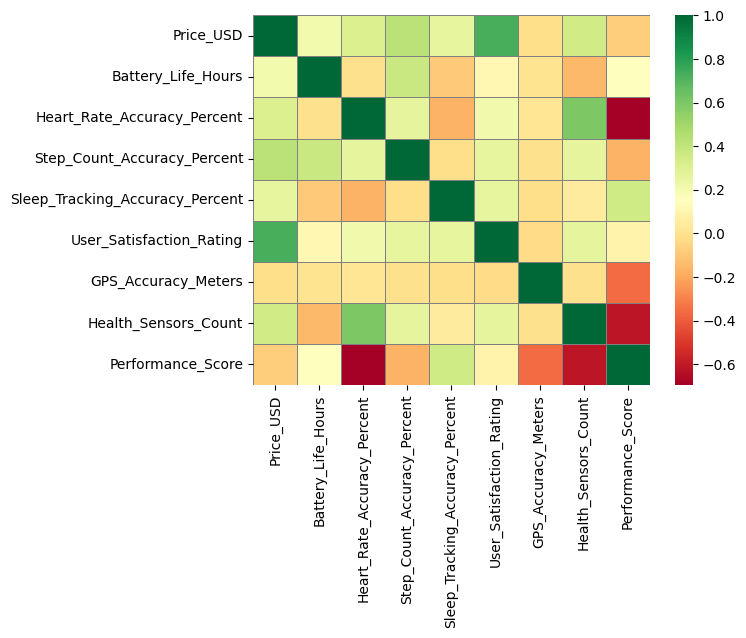

In [92]:
# For the sake of time, I will import the ols_model function and remove_correlated_variables function from User_Satisfaction_Analysis
correlation_matrix = df.corr(method='pearson', numeric_only=True)

sns.heatmap(data=correlation_matrix, cmap='RdYlGn', linecolor='gray', linewidths=0.5)


# Let's first test some features I personally believe should/would contribute to performance
print(df.columns.tolist())
performance_features = ['Battery_Life_Hours', 'Heart_Rate_Accuracy_Percent', 
                        'Step_Count_Accuracy_Percent', 'Sleep_Tracking_Accuracy_Percent', 
                        'Water_Resistance_Rating', 'GPS_Accuracy_Meters', 
                        'Health_Sensors_Count']
performance_features_r2 = ols_model(x=df[performance_features], y=df['Performance_Score'], return_details=True)
display(performance_features_r2)

Based on the R^2 score, we can see that the features that I assumed would contribute most to the performance only contribute to ~49% of the variance explained in Performance_Score. Let's now look into what features actually contribute most to the performance score through the removal of multi-collinearity and filtering down to our final features.

REMOVE HIGHLY CORRELATED VARIABLES


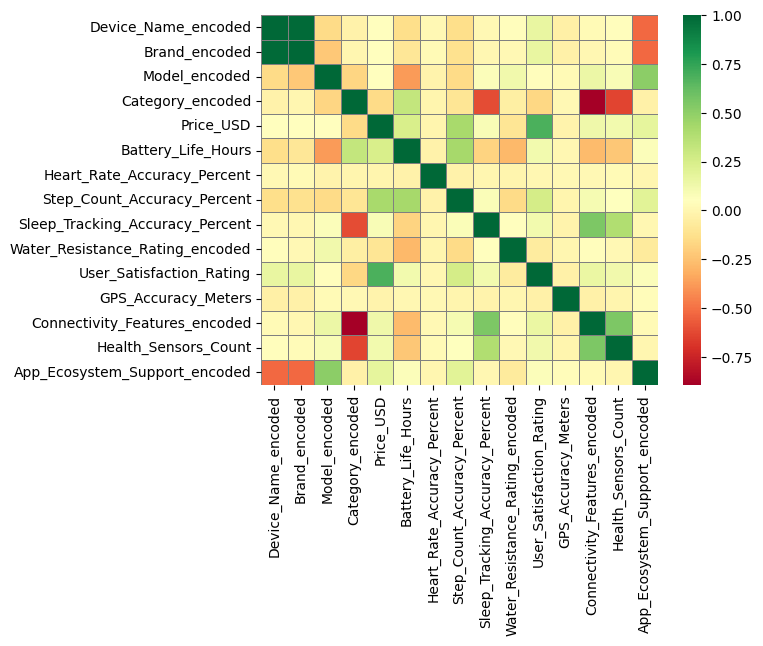

Correlation threshold: 0.8
Variables removed: 2
Variables remaining: 13

Removed pairs:
   Removed Device_Name (kept Brand) - correlation: 0.990
   Removed Connectivity_Features (kept Category) - correlation: -0.892

Final feature set:
   - Brand
   - Model
   - Category
   - Price_USD
   - Battery_Life_Hours
   - Heart_Rate_Accuracy_Percent
   - Step_Count_Accuracy_Percent
   - Sleep_Tracking_Accuracy_Percent
   - Water_Resistance_Rating
   - User_Satisfaction_Rating
   - GPS_Accuracy_Meters
   - Health_Sensors_Count
   - App_Ecosystem_Support
x is a Dataframe
Data appears to be already encoded, using as-is


,Brand_encoded,Model_encoded,Category_encoded,Price_USD,Battery_Life_Hours,Heart_Rate_Accuracy_Percent,Step_Count_Accuracy_Percent,Sleep_Tracking_Accuracy_Percent,Water_Resistance_Rating_encoded,User_Satisfaction_Rating,GPS_Accuracy_Meters,Health_Sensors_Count,App_Ecosystem_Support_encoded
1,1,20,0,834.64,26.5,95.92,98.20,79.76,2,8.3,4.9,8,2
2,2,17,1,145.34,161.2,92.24,96.81,74.49,3,6.0,1.7,7,1
3,5,15,0,349.53,69.4,96.77,95.56,78.06,2,8.0,3.2,12,1
4,6,7,0,502.43,39.7,92.27,98.15,75.23,3,8.3,1.6,14,0
5,3,3,0,402.32,287.4,92.85,99.34,77.58,1,8.1,2.3,11,1



Model performance after removing correlated variables:
model: LinearRegression()
train_r2: 0.9141551704023452
test_r2: 0.8954071636199893
train_rmse: 0.5779148327801835
test_rmse: 0.5976648540616487


In [93]:
final_features, model_score = remove_correlated_variables(df=df, features=df.drop(columns=['Performance_Score', 'Test_Date']).columns.tolist(), target='Performance_Score' )

In [94]:
# Individual R2 Analysis
feature_dict = {}
for i, feature in enumerate(final_features):
    if str(feature).endswith('_encoded'):
        feature = str(feature).replace('_encoded', '')
    feature_score = ols_model(x=df[feature], y=df['Performance_Score'], return_details=False)
    feature_dict.update({feature: feature_score})

sorted_features = sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)

x is a Series
Series contains categorical data, encoding...
Converted Series to DataFrame with shape (2375, 1)
x is a Series
Series contains categorical data, encoding...
Converted Series to DataFrame with shape (2375, 1)
x is a Series
Series contains categorical data, encoding...
Converted Series to DataFrame with shape (2375, 1)
x is a Series
Series contains numerical data, using as-is
Converted Series to DataFrame with shape (2375, 1)
x is a Series
Series contains numerical data, using as-is
Converted Series to DataFrame with shape (2375, 1)
x is a Series
Series contains numerical data, using as-is
Converted Series to DataFrame with shape (2375, 1)
x is a Series
Series contains numerical data, using as-is
Converted Series to DataFrame with shape (2375, 1)
x is a Series
Series contains numerical data, using as-is
Converted Series to DataFrame with shape (2375, 1)
x is a Series
Series contains categorical data, encoding...
Converted Series to DataFrame with shape (2375, 1)
x is a Seri

In [87]:
for i in sorted_features:
    print(f'{i[0]} R^2: {i[1]}')

Heart_Rate_Accuracy_Percent R^2: 0.456990065055916
Category R^2: 0.4376654959389761
Health_Sensors_Count R^2: 0.34269976596149254
GPS_Accuracy_Meters R^2: 0.15161108812461555
Model R^2: 0.10702656570196556
Sleep_Tracking_Accuracy_Percent R^2: 0.08489380998036444
Water_Resistance_Rating R^2: 0.01236426604476859
Battery_Life_Hours R^2: 0.006182632010716227
Brand R^2: 0.005047131606415123
App_Ecosystem_Support R^2: 0.0022825116056403028
User_Satisfaction_Rating R^2: 0.001634075982520411
Price_USD R^2: -0.0063648356438081866
Step_Count_Accuracy_Percent R^2: -0.012320333842117392


In the above cell, we have sorted the features by their individual contributions to Performance_Score. We see that most of the variance in Performance_Score can be explained by heart rate accuracy, the category of the watch, and the number of heath sensors.
Furthermore, we see that there are 2 values containing negative R2 scores. We should look into what happens to the overall R2 score when we remove those from our feature set.

In [95]:
negative_features = ['Price_USD', 'Step_Count_Accuracy_Percent']
non_negative_features = [feature[0] for feature in sorted_features if feature[1] > 0]
non_negative_r2 = ols_model(x=df[non_negative_features], y=df['Performance_Score'], return_details=False)
print(f'Non-negative feature R2: {non_negative_r2}')
print()

x is a Dataframe


,Heart_Rate_Accuracy_Percent,Category,Health_Sensors_Count,GPS_Accuracy_Meters,Model,Sleep_Tracking_Accuracy_Percent,Water_Resistance_Rating,Battery_Life_Hours,Brand,App_Ecosystem_Support,User_Satisfaction_Rating,Category_encoded,Model_encoded,Water_Resistance_Rating_encoded,Brand_encoded,App_Ecosystem_Support_encoded
1,95.92,Smartwatch,8,4.9,Watch SE 3,79.76,IP68,26.5,Apple,iOS,8.3,0,20,2,1,2
2,92.24,Sports Watch,7,1.7,Versa 4,74.49,IPX8,161.2,Fitbit,Cross-platform,6.0,1,17,3,2,1
3,96.77,Smartwatch,12,3.2,Vantage V3,78.06,IP68,69.4,Polar,Cross-platform,8.0,0,15,2,5,1
4,92.27,Smartwatch,14,1.6,Galaxy Watch FE,75.23,IPX8,39.7,Samsung,Android/iOS,8.3,0,7,3,6,0
5,92.85,Smartwatch,11,2.3,Forerunner 965,77.58,5ATM,287.4,Garmin,Cross-platform,8.1,0,3,1,3,1


Non-negative feature R2: 0.8533556561846108


Based on this R^2 score, we can see that the negative features actually do help to explain the variance in Performance Score. As a result, we will leave the features as is and denote the final features as:
- 'Brand_encoded'
- 'Model_encoded'
- 'Category_encoded'
- 'Price_USD'
- 'Battery_Life_Hours'
- 'Heart_Rate_Accuracy_Percent'
- 'Step_Count_Accuracy_Percent'
- 'Sleep_Tracking_Accuracy_Percent'
- 'Water_Resistance_Rating_encoded'
- 'User_Satisfaction_Rating'
- 'GPS_Accuracy_Meters'
- 'Health_Sensors_Count'
- 'App_Ecosystem_Support_encoded'